In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random
from datetime import timedelta  

In [2]:
dpath = {}
dpath['home'] = './data/conflicts'
dpath['subfolder'] = 'input'
dpath['filename'] = '2001-01-01-2019-10-01-Djibouti-Ethiopia-Kenya-Somalia.csv'
dfc = pd.read_csv(os.path.join(dpath['home'],dpath['subfolder'],dpath['filename']))

# Filtering for somalian cases
dfc = dfc[[i[:3] == 'SOM' for i in dfc['event_id_cnty'].values]]

# Dropping peaceful protests
dfc = dfc.drop(dfc[dfc['sub_event_type'] == 'Peaceful protest'].index)

# Typesetting
dfc['ts'] = pd.to_datetime(dfc['event_date'])
dfc['latitude'] = dfc['latitude'].astype(float)
dfc['longitude'] = dfc['longitude'].astype(float)
dfc['fatalities'] = dfc['fatalities'].astype(int)

dfc = dfc[['ts','latitude','longitude','fatalities']]
dfc.columns = ['ts','lat','lon','fatalities']

# Write to csv
dpath = {}
dpath['home'] = './data/conflicts'
dpath['subfolder'] = 'input'
dpath['filename'] = '2001-01-01-2019-10-01-Somalia-Events-Only.csv'
# dfc.to_csv(os.path.join(dpath['home'],dpath['subfolder'],dpath['filename']))

### Somalian geodata

In [3]:
dfg = gpd.read_file("geodata_somalia/som_admbnda_adm2_undp.shp")
dfg = dfg.sort_values(by='admin2Name')

dfg = dfg[['admin2Name','admin1Name','admin0Name', 'Shape_Area','geometry']]

dfg.loc[dfg[dfg['admin2Name'] == 'Baydhaba'].index,'admin2Name'] = 'Baidoa'
dfg.loc[dfg[dfg['admin2Name'] == 'Kismaayo'].index,'admin2Name'] = 'Kismayo'

dfg['regdis'] = dfg['admin1Name'] + ' - ' + dfg['admin2Name'] 

dfg = dfg[['regdis','geometry','Shape_Area']]
dfg.head()

,regdis,geometry,Shape_Area
44,Middle Shabelle - Adan Yabaal,"POLYGON ((46.80133438200005 3.198667049000051,...",0.323930
49,Lower Shabelle - Afgooye,"POLYGON ((45.20855963400004 1.95408072500004, ...",0.321784
71,Lower Juba - Afmadow,POLYGON ((41.00145721400003 -0.196484296999926...,2.174108
62,Gedo - Baardheere,"POLYGON ((42.54262161300005 2.751026392000028,...",1.241769
72,Lower Juba - Badhaadhe,(POLYGON ((41.92670440600006 -1.16192197799995...,0.793048


In [4]:
dfc.head()

,ts,lat,lon,fatalities
1,2019-09-28,1.7131,44.7639,2
2,2019-09-28,1.9833,44.8333,0
3,2019-09-28,-0.3603,42.5463,9
4,2019-09-28,2.4492,45.3542,1
5,2019-09-28,1.9833,44.8333,10


In [5]:
from shapely.geometry import Point, Polygon

# Function that return the area in string format based on the input (lat,long) coordinates 'x'
def point_in_which_area(p,df,feat):
    P = Point(p)
    geoms = df.loc[:,'geometry']
    filt = [P.within(geom) for geom in geoms]
    return str(df.loc[filt][feat].values).strip("['']")

# Write areas to dataframe
points = [(lon,lat) for lat,lon in dfc[['lat','lon']].values]
dfc['regdis'] = [point_in_which_area(p,dfg,'regdis') for p in points]

# Drop unplaces conflicts
dfc = dfc.drop(dfc[dfc['regdis'] == ''].index)

In [6]:
dfc['fatalities'].sum()

49054

In [7]:
# Hyperparameters for heatmap construction
T = 1 # Period frequency 1, 2, 3 ,4 
freq = 'W' # Date frequency that can be D, W, M for Days, Weeks, Months and so on

# Aggregate (time, square, category) to create the incident map sum 
df = dfc.groupby(['regdis','fatalities', pd.Grouper(key='ts', freq=freq)],as_index=True).sum()

df = df.reset_index()
df = df[['ts','regdis','fatalities']]

df = df.groupby(['ts','regdis'],as_index=False).sum()
df = df.pivot(index='ts',columns='regdis',values='fatalities')

df = df.fillna(0)

In [8]:
df.sum().sum()

42531.0

In [10]:
dfc.head()

,ts,lat,lon,fatalities,regdis
1,2019-09-28,1.7131,44.7639,2,Lower Shabelle - Marka
2,2019-09-28,1.9833,44.8333,0,Lower Shabelle - Afgooye
3,2019-09-28,-0.3603,42.5463,9,Lower Juba - Kismayo
4,2019-09-28,2.4492,45.3542,1,Middle Shabelle - Balcad
5,2019-09-28,1.9833,44.8333,10,Lower Shabelle - Afgooye


In [92]:
dpath = {}
dpath['home'] = './data/conflicts'
dpath['subfolder'] = 'output'
dpath['filename'] = 'Somalia-Conflict-2001-2019-DistrictLevel-Weekly.csv'
df.to_csv(os.path.join(dpath['home'],dpath['subfolder'],dpath['filename']))

# Visualization

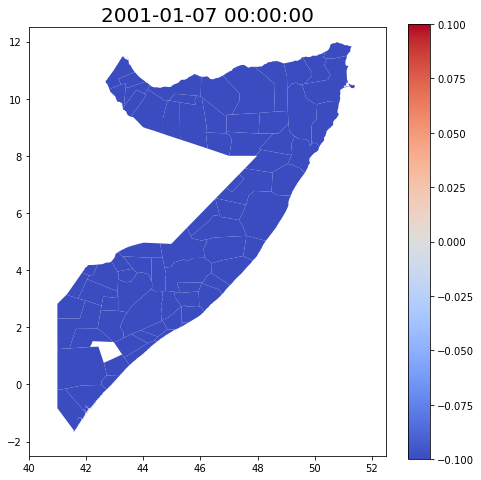

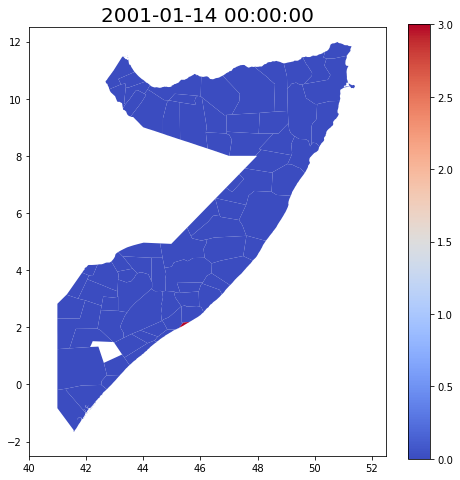

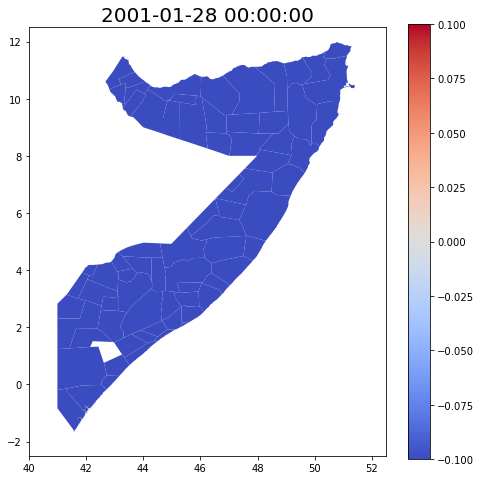

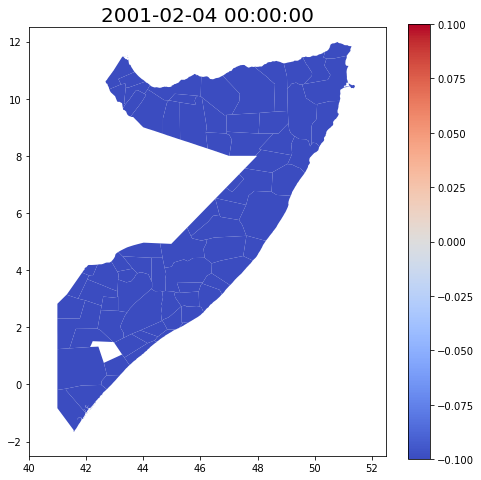

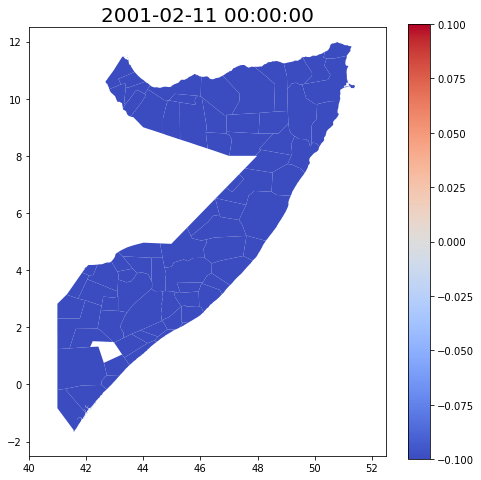

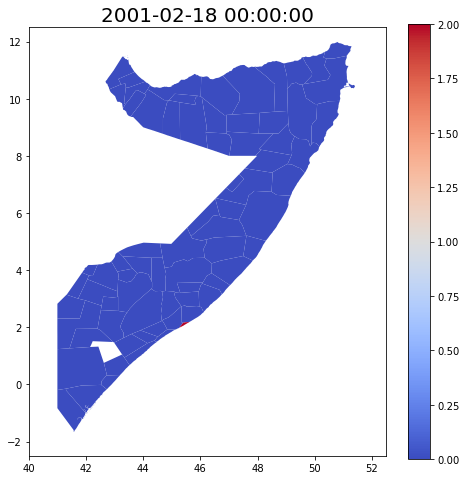

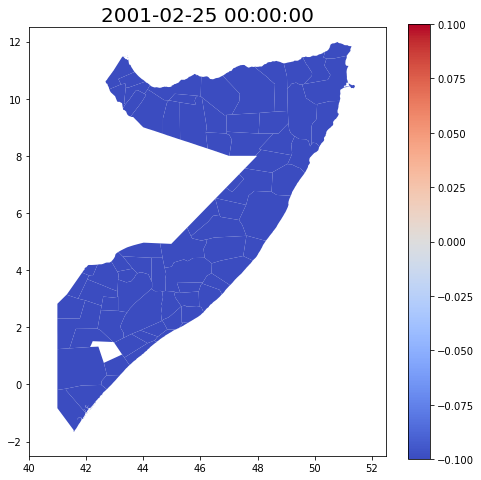

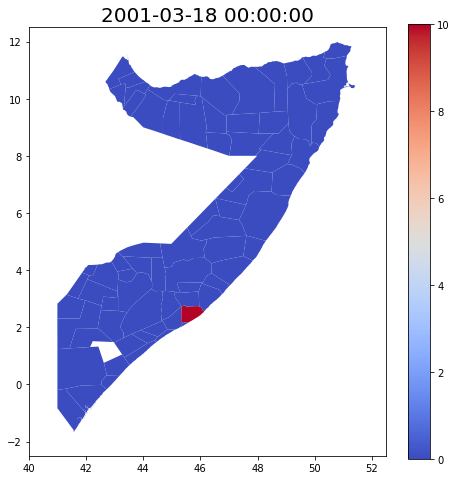

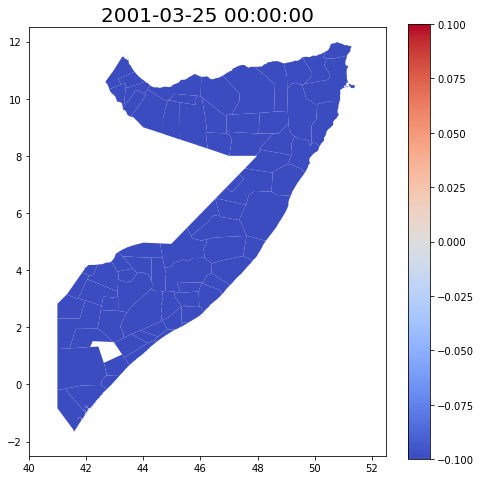

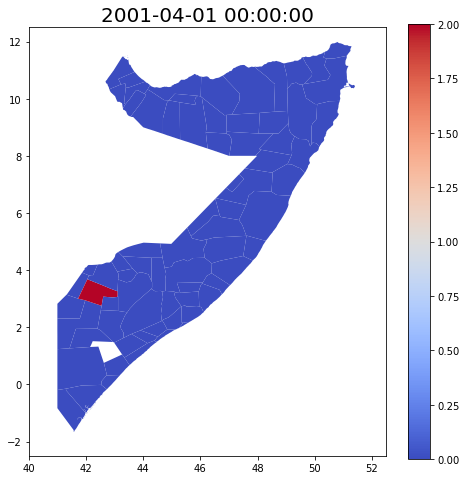

In [94]:
for ind in range(0,10):
    tsi = df.index[ind]

    x = pd.DataFrame(df.loc[tsi,:].reset_index())
    x.columns=['regdis','individuals']

    # Plot settings
    fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'aspect':'equal'})
    ax.set_xlim(40, 52.5)
    ax.set_ylim(-2.5,12.5)
    #ax.set_axis_off()
    imtitle = str(tsi)
    ax.set_title(imtitle, size = 20)

    # Plot satellite data on top of natural earth
    dfg.merge(x).plot(ax=ax, column='individuals', cmap='coolwarm', legend=True);

    dpath = {}
    dpath['home'] = './data/conflicts'
    dpath['subfolder'] = 'images/district_weekly'
    dpath['filename'] = imtitle

    fig.savefig(os.path.join(dpath['home'],dpath['subfolder'],dpath['filename']))